In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
from astropy.io import fits

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175, Omega_b = 0.049, h = 0.6711, sigma8 = 0.834, n_s = 0.9649, 
                      matter_power_spectrum='linear')
h     = cosmo.cosmo.params.h

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar_S19 = dict(theta_ej = 4, theta_co = 0.1, M_c = 1e14/h, mu_beta = 0.4,
                eta = 0.3, eta_delta = 0.3, tau = -1.5, tau_delta = 0, #Must use tau here since we go down to low mass
                A = 0.09/2, M1 = 2.5e11/h, epsilon_h = 0.015, 
                a = 0.3, n = 2, epsilon = 4, p = 0.3, q = 0.707, gamma = 2, delta = 7)

bpar_A20 = dict(alpha_g = 2, epsilon_h = 0.015, M1_0 = 2.2e11/h, 
                alpha_fsat = 1, M1_fsat = 1, delta_fsat = 1, gamma_fsat = 1, eps_fsat = 1,
                M_c = 1.2e14/h, eta = 0.6, mu = 0.31, beta = 0.6, epsilon_hydro = np.sqrt(5),
                M_inn = 3.3e13/h, M_r = 1e16, beta_r = 2, theta_inn = 0.1, theta_out = 3,
                theta_rg = 0.3, sigma_rg = 0.1, a = 0.3, n = 2, p = 0.3, q = 0.707,
                A_nt = 0.495, alpha_nt = 0.1,
                mean_molecular_weight = 0.59)

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

# Calculate fractions

We just compute the fraction of a given matter component within R200c. You can change the radius by swapping the mass-definition consistently throughout the code. 

### All profile classes accept mdef inputs, so make sure to consistently set this in all profiles

In [3]:
#Compute the mass fraction given a profile class
def compute_mass_fraction(Profile, Mass, a = 1, Rfac = 1):
    
    #Always use 200c (can change this if you want)
    mdef  = ccl.halos.massdef.MassDef200c
    R200c = mdef.get_radius(cosmo, Mass, a) / a #Physical back to comoving
    
    out   = np.zeros_like(Mass) + -99
    
    #Loop over masses and compute mass fraction for each
    for i in range(Mass.size):
        
        r = np.geomspace(R200c[i] * 1e-4, R200c[i] * Rfac, 1000) #Only eval at r < R200c
        m = np.trapz(4 * np.pi * r**2 * Profile.real(cosmo, r, Mass[i], a), x = r) #Cumulative mass fraction
        
        out[i] = m/Mass[i] #Fraction
        
    return out

# HMCode variations

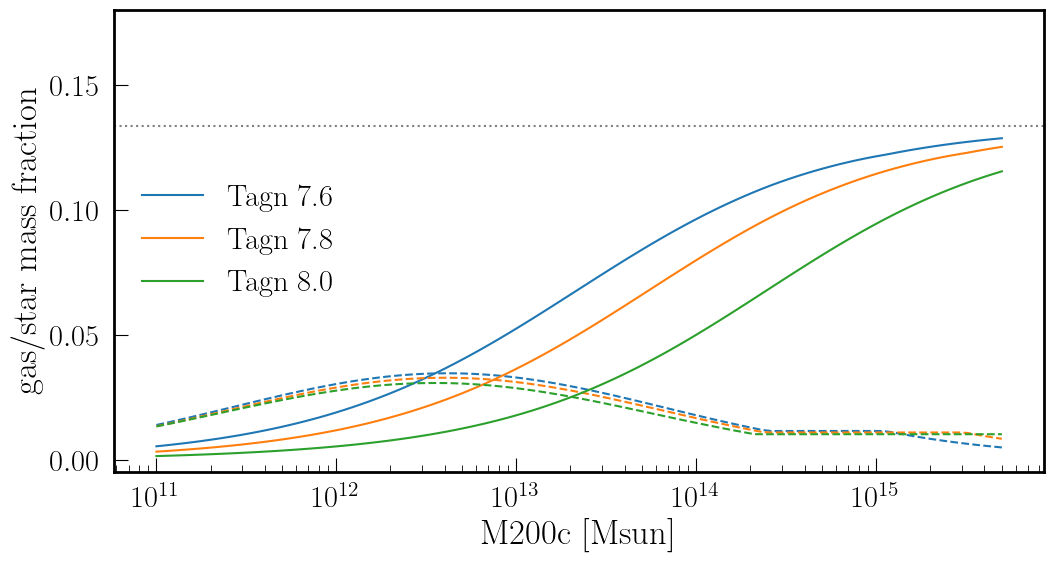

In [4]:
plt.figure(figsize = (12,6))
plt.xscale('log')

M200c = np.geomspace(1e11, 5e15, 100)

pars = [bfg.Profiles.Mead20.Params_TAGN_7p6_MPr, bfg.Profiles.Mead20.Params_TAGN_7p8_MPr, bfg.Profiles.Mead20.Params_TAGN_8p0_MPr]
labs = ['Tagn 7.6', 'Tagn 7.8', 'Tagn 8.0']

#Loop over HMCode models and plot for all
for par, label in zip(pars, labs):
    
    GAS = bfg.Profiles.Mead20.Gas(**par, mass_def = ccl.halos.massdef.MassDef200c)
    STR = bfg.Profiles.Mead20.Stars(**par, mass_def = ccl.halos.massdef.MassDef200c)

    fgas  = compute_mass_fraction(GAS, M200c)
    fstr  = compute_mass_fraction(STR, M200c)

    c = plt.plot(M200c, fgas, ls = '-', label = label)
    plt.plot(M200c, fstr, ls = '--', color = c[0].get_color())
    
    
#Cosmic baryon fraction for reference
fb = cosmo.cosmo.params.Omega_b / cosmo.cosmo.params.Omega_m
plt.axhline(fb, color = 'k', ls = ':', alpha = 0.5)

plt.ylim(None, 0.18)
plt.legend()
plt.ylabel('gas/star mass fraction', size = 25)
plt.xlabel('M200c [Msun]', size = 25)
plt.tick_params(pad = 10)
plt.show()

# Variations across models

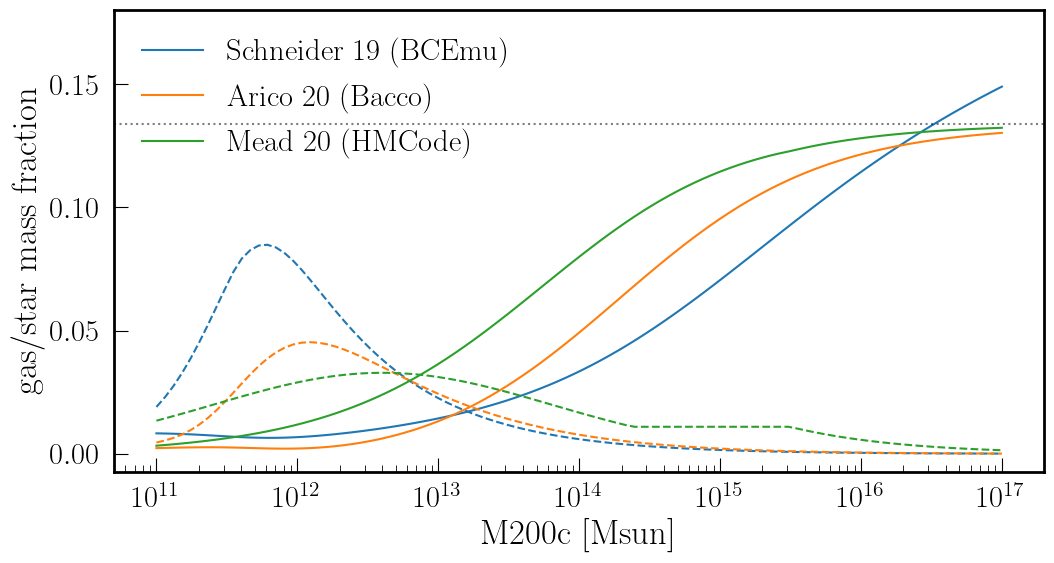

In [5]:
plt.figure(figsize = (12,6))
plt.xscale('log')

M200c = np.geomspace(1e11, 1e17, 100)

Analysis_setup = {
    'Schneider 19 (BCEmu)' : [bfg.Profiles.Schneider19, bpar_S19],
    'Arico 20 (Bacco)'     : [bfg.Profiles.Arico20,     bpar_A20],
    'Mead 20 (HMCode)'     : [bfg.Profiles.Mead20,      bfg.Profiles.Mead20.Params_TAGN_7p8_MPr]
}


#Explicitly specify Duffy because Arico and Mead use this
c_M_relation = ccl.halos.concentration.ConcentrationDuffy08

for k, A in Analysis_setup.items():
    
    GAS = A[0].Gas(**A[1], c_M_relation = c_M_relation, mass_def = ccl.halos.massdef.MassDef200c)
    STR = A[0].Stars(**A[1], c_M_relation = c_M_relation, mass_def = ccl.halos.massdef.MassDef200c)

    fgas  = compute_mass_fraction(GAS, M200c)
    fstr  = compute_mass_fraction(STR, M200c)

    c = plt.plot(M200c, fgas, ls = '-', label = k)
    plt.plot(M200c, fstr, ls = '--', color = c[0].get_color())
    
    
fb = cosmo.cosmo.params.Omega_b / cosmo.cosmo.params.Omega_m
plt.axhline(fb, color = 'k', ls = ':', alpha = 0.5)

plt.ylim(None, 0.18)
plt.legend()
plt.ylabel('gas/star mass fraction', size = 25)
plt.xlabel('M200c [Msun]', size = 25)
plt.tick_params(pad = 10)
plt.show()

# Schneider $f_{\rm gas}$ on larger scales

The blue line above clearly exceeds the cosmic gas fraction. But this is not a problem because the gas fraction is allowed to be in excess of the cosmic mean when looking at small volume around the peak of a collapsed structure. Once we compute fractions within larger-scales, we converge to the cosmic limit like expected. The below plots show this.

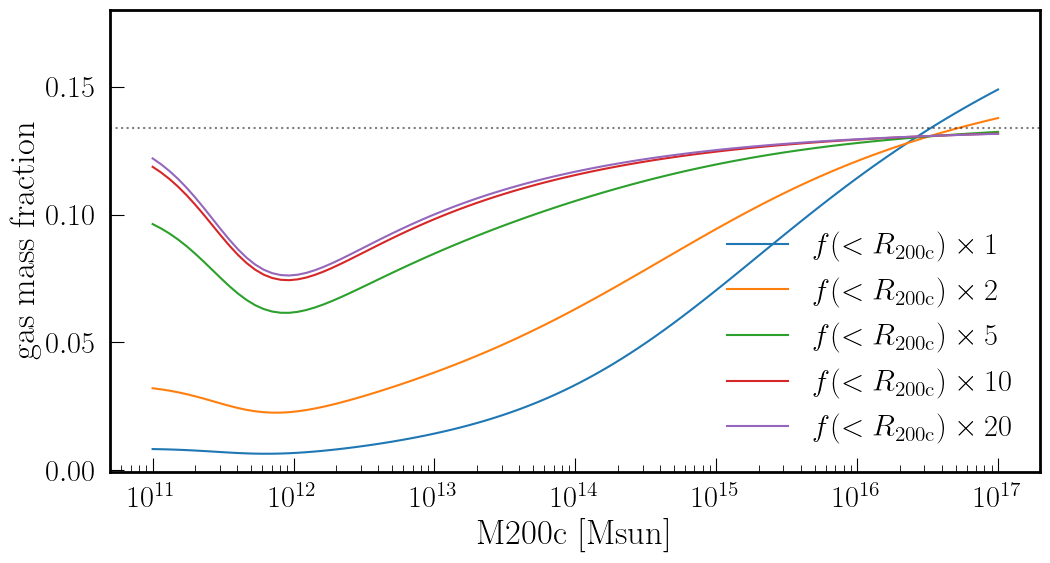

In [6]:
plt.figure(figsize = (12,6))
plt.xscale('log')

M200c = np.geomspace(1e11, 1e17, 100)

#Explicitly specify Duffy because Arico and Mead use this
c_M_relation = ccl.halos.concentration.ConcentrationDuffy08
A = [bfg.Profiles.Schneider19, bpar_S19]

for rfac in [1, 2, 5, 10, 20]:
    
    GAS = A[0].Gas(**A[1], c_M_relation = c_M_relation, mass_def = ccl.halos.massdef.MassDef200c)
    STR = A[0].Stars(**A[1], c_M_relation = c_M_relation, mass_def = ccl.halos.massdef.MassDef200c)
    DMO = A[0].DarkMatter(**A[1], c_M_relation = c_M_relation, mass_def = ccl.halos.massdef.MassDef200c)

    fgas  = compute_mass_fraction(GAS, M200c, Rfac = rfac) / compute_mass_fraction(DMO, M200c, Rfac = rfac)

    c = plt.plot(M200c, fgas, ls = '-', label = fr'$f(<R_{{\rm 200c}}) \times {rfac}$')    
    
fb = cosmo.cosmo.params.Omega_b / cosmo.cosmo.params.Omega_m
plt.axhline(fb, color = 'k', ls = ':', alpha = 0.5)

plt.ylim(None, 0.18)
plt.legend()
plt.ylabel('gas mass fraction', size = 25)
plt.xlabel('M200c [Msun]', size = 25)
plt.tick_params(pad = 10)
plt.show()